Iteration 0: Best so far is 35 steps for a distance of 34.000000
best_route [  0 567 708 810 580 805 901 448 804 192 756 539 181 167 310 122  30 902
 538 679 704 565 478 316 620 638 855  42 414 292 181 724 286 251 999]
Iteration 4: Best so far is 16 steps for a distance of 15.000000
best_route [  0 567 708 810 580 805 901 448 804 192 756 539 181 167  16 999]
Iteration 6: Best so far is 15 steps for a distance of 14.000000
best_route [  0 621 389 706 747 191 284 186 853 891  92 181 167  16 999]
Iteration 12: Best so far is 9 steps for a distance of 8.000000
best_route [  0 621 365 700 491 602 662 809 999]
Iteration 27: Best so far is 5 steps for a distance of 4.000000
best_route [  0 875 337 632 999]
Origin: 0 Goal: 999
N: 1000 Iterations: 1000 Data: data1000-1000a.csv
Sparsity: 0.65
Blocked: [155]
Path length: 4
Shortest path: [  0 875 337 632 999]
Time: 52.747963428497314


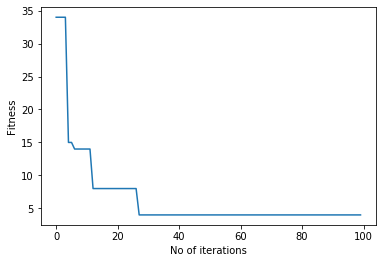

In [38]:
import numpy as np
import random
import copy
import time
from generate_data import initialize_matrix,visualize_graph
import pylab as pl

def generate_initial_population(size, matrix):
    population = []
    for i in range(0, size):
        population.append(generate_new_solution(matrix))
    return population

def generate_new_solution(matrix):
    N = len(matrix)
    route = np.zeros(1, dtype=int)
    go = True
    i = 1
    while go:
        possible_values = np.nonzero(matrix[route[i - 1]])
        proposed_value = random.randint(0, len(possible_values[0]) - 1)
        route = np.append(route, possible_values[0][proposed_value])
        if route[i] == N - 1:
            go = False
        else:
            i += 1
    return route

def calculate_fitness(route, the_map):
    score = 0
    for i in range(1, len(route)):
        if (the_map[route[i - 1]][route[i]] == 0) and i != len(the_map) - 1:
            print("Invalid route...")
        score = score + the_map[route[i - 1]][route[i]]
    return score

def find_crossover(route1, route2):
    common_elements = set(route1) & set(route2)
    if len(common_elements) == 2:
        return (route1, route2)
    else:
        common_elements.remove(0)
        common_elements.remove(max(route1))
        value = random.sample(common_elements, 1)
    cut_a = np.random.choice(np.where(np.isin(route1, value))[0])
    cut_b = np.random.choice(np.where(np.isin(route2, value))[0])
    new_a1 = copy.deepcopy(route1[0:cut_a])
    new_a2 = copy.deepcopy(route2[cut_b:])
    new_b1 = copy.deepcopy(route2[0:cut_b])
    new_b2 = copy.deepcopy(route1[cut_a:])
    new_a = np.append(new_a1, new_a2)
    new_b = np.append(new_b1, new_b2)
    return (new_a, new_b)

def score_population(population, matrix):
    scores = []
    for i in range(0, len(population)):
        scores += [calculate_fitness(population[i], matrix)]
    return scores

def select_population(scores):
    array = np.array(scores)
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    fitness = [len(ranks) - x for x in ranks]
    cum_scores = copy.deepcopy(fitness)
    for i in range(1, len(cum_scores)):
        cum_scores[i] = fitness[i] + cum_scores[i - 1]
    probs = [x / cum_scores[-1] for x in cum_scores]
    rand = random.random()
    for i in range(0, len(probs)):
        if rand < probs[i]:
            return i

def mutation(route, probability, matrix):
    new_route = copy.deepcopy(route)
    for i in range(1, len(new_route)):
        if random.random() < probability:
            go = True
            while go:
                possible_values = np.nonzero(matrix[new_route[i - 1]])
                proposed_value = random.randint(0, len(possible_values[0]) - 1)
                route = np.append(new_route, possible_values[0][proposed_value])
                if new_route[i] == len(matrix) - 1:
                    go = False
                else:
                    i += 1
    return new_route

def check_path(mat, path):
    result = 'Correct path'
    for idx in range(len(path)-1):
        if mat[path[idx]][path[idx+1]] != 1:
            print(mat[path[idx]][path[idx+1]], "wrong")
            result = None
    if result:
        print(result)

def block(nodes, adjacency_matrix):
    matrix = np.asmatrix(adjacency_matrix)
    for node in nodes:
        blocked = np.where(adjacency_matrix[:, node] == 1)
        adjacency_matrix[blocked[0], node] = 100
    return adjacency_matrix


def run_genetic_algorithm(matrix):
    population_size = 25
    number_of_iterations = 100
    number_of_couples = 9
    number_of_winners_to_keep = 2
    mutation_probability = 0.05
    population = generate_initial_population(population_size, matrix)
    last_distance = np.inf
    total_pop_length = 0
    best_scorer_count = 0
    list_of_distances = []
    for i in range(0, number_of_iterations):
        new_population = []
        population_lengths = [i.size for i in population]
        sum_of_population_lengths = np.sum(population_lengths)
        total_pop_length = total_pop_length + sum_of_population_lengths
        """
        if(total_pop_length>=1000):
            break;
        """
        scores = score_population(population, matrix)
        best = population[np.argmin(scores)]
        number_of_moves = len(best)
        distance = calculate_fitness(best, matrix)
        list_of_distances.append(distance)
        if distance != last_distance:
            print('Iteration %i: Best so far is %i steps for a distance of %f' % (i, number_of_moves, distance))
            print("best_route", best)
            best_scorer_count = best_scorer_count + 1
        """
        if (best_scorer_count > 30):
            break
        """
        for j in range(0, number_of_couples):
            new_1, new_2 = find_crossover(population[select_population(scores)], population[select_population(scores)])
            new_population = new_population + [new_1, new_2]
        for j in range(0, len(new_population)):
            new_population[j] = np.copy(mutation(new_population[j], mutation_probability, matrix))
        new_population += [population[np.argmin(scores)]]
        for j in range(1, number_of_winners_to_keep):
            keeper = select_population(scores)
            new_population += [population[keeper]]
        while len(new_population) < population_size:
            new_population += [generate_new_solution(matrix)]
        population = copy.deepcopy(new_population)
        last_distance = distance
    return list_of_distances,best


"""
sparseness_of_map = 0.96
size_of_map = 100
matrix,edges = initialize_matrix(sparseness_of_map, size_of_map)
print(matrix)
print(visualize_graph(matrix))
matrix = [
        [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
        ]
"""


def loadfromfile(filename ='data.csv'):
    matrix = np.loadtxt(filename,delimiter=',')
    return matrix


if __name__ == "__main__":
    start = time.time()
    file_exists = True
    rounds = 1000
    if file_exists:
        matrix = loadfromfile(filename='data1000-10000.csv')
        prob_sparsity = 0.65
    else:
        N = 10
        prob_sparsity = 0.65
        matrix, edges = initialize_matrix(prob_sparsity, N)
        np.savetxt('data'+str(N)+'-'+str(rounds)+'a.csv', matrix, delimiter=',')
    goal = matrix.shape[0]-1
    origin = 0
    #block_nodes = [246,31]
    block_nodes = [155]
    matrix = block(block_nodes, matrix)
    list_of_distance,best = run_genetic_algorithm(matrix)
    print("============================================================================")
    print("Origin:", origin, "Goal:", goal)
    print("N:", matrix.shape[0], "Iterations:", rounds, "Data:", 'data' + str(matrix.shape[0]) + '-' + str(rounds) + 'a.csv')
    print("Sparsity:", prob_sparsity)
    print("Blocked:", block_nodes)
    print("Path length:", len(best) - 1)
    print("Shortest path:", best)
    print("Time:",time.time() - start)
    pl.plot(list_of_distance)
    pl.xlabel('No of iterations')
    pl.ylabel('Fitness')
    pl.show()
